In [1]:
import geopandas as gpd
import pandas as pd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import rtree

In [8]:
#Variables para las rutas de información
usuario = 'u519914'
data_path = '/us/'+usuario+'/lava_iniciative/data/'

Traemos el archivo con  la información geográfica de las secciones censales del INE

In [11]:
df_INE=gpd.read_file(data_path+'SECC_CPV_E_20111101_01_R_INE.shp', encoding='utf8')

In [4]:
df_INE.shape

(35960, 22)

In [5]:
df_INE.dtypes

CCA            object
CDIS           object
CLAU2          object
CMUN           object
CNUT0          object
CNUT1          object
CNUT2          object
CNUT3          object
CPRO           object
CSEC           object
CUDIS          object
CUMUN          object
CUSEC          object
NCA            object
NMUN           object
NPRO           object
OBJECTID        int64
OBS            object
Shape_Leng    float64
Shape_area    float64
Shape_len     float64
geometry       object
dtype: object

In [6]:
# Generamos un data frame por municipio
mad_INE=df_INE[(df_INE['CPRO']=='28') & (df_INE['CMUN']=='079')]
bcn_INE=df_INE[(df_INE['CPRO']=='08') & (df_INE['CMUN']=='019')]

In [7]:
#una forma cutre de hacer un contador de elementos diferentes de la columna
mad_INE.groupby('CUSEC').CUSEC.nunique().shape

(2409,)

In [8]:
bcn_INE.groupby('CUSEC').CUSEC.nunique().shape

(1061,)

In [9]:
# Cargamos la información del CSV de madiva
madiva=pd.read_csv(data_path + 'madiva_geo.csv', sep=",", decimal=",")


In [10]:
#creamos el nuevo dataframe, uniendo por secciones censales
INE_madiva=df_INE.merge(madiva,how='inner',left_on='CUSEC',right_on='PRO+MUN+DIS+SEC')

KeyError: 'PRO+MUN+DIS+SEC'

Traemos el resto de archivos

In [20]:

# Cargamos los datos de los ficheros json
ine_features=pd.read_csv(r'C:\Users\e001255\Desktop\Madiva\data\INE\INE_all.csv',sep=";",decimal=",")
bibliotecas=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\bibliotecas.geojson')
bomberos=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\bomberos.geojson')
cines=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\cines.geojson')
colegios=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\colegios.geojson')
farmacias=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\farmacias.geojson')
guarderias=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\guarderias.geojson')
hospitales=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\hospitales.geojson')
hoteles=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\hoteles.geojson')
monumentos=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\monumentos.geojson')
museos=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\museos.geojson')
parques=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\parques.geojson')
piscinas=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\piscinas.geojson')
pistas=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\pistas.geojson')
policia=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\policia.geojson')
polideportivos=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\polideportivos.geojson')
teatros=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\teatros.geojson')
universidades=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\universidades.geojson')
veterinarios=gpd.read_file(r'C:\Users\e001255\Desktop\Madiva\data\explicativas\drive-download-20170219T210440Z\veterinarios.geojson')


In [ ]:
# se ve que hay atributos que pueden ser tanto polígonos como puntos
bibliotecas.shape


Cómo los datos de Madiva son variables numéricas, las pasamos a texto para
poder tener un código de 10 caracteres (2 provincia, 3 municipio, 2 distrito censal,
3 sección censal). Una vez hecho eso creamos un muevo dataframe que une INE y Madiva

In [30]:
INE_madiva.dtypes

CCA                              object
CDIS                             object
CLAU2                            object
CMUN                             object
CNUT0                            object
CNUT1                            object
CNUT2                            object
CNUT3                            object
CPRO                             object
CSEC                             object
CUDIS                            object
CUMUN                            object
CUSEC                            object
NCA                              object
NMUN                             object
NPRO                             object
OBJECTID                          int64
OBS                              object
Shape_Leng                      float64
Shape_area                      float64
Shape_len                       float64
geometry                         object
centroid                         object
cartodb_id                        int64
the_geom                         object


cruzamos los dataframes, para que cada variables explicativas esté asignada a su(s)
secciones censales. Primero generamos un archivo para Madrid y otro para Barcelona,
y con estos vamos interseccionando los datos

In [31]:
mad=INE_madiva[(INE_madiva['CPRO']=='28') & (INE_madiva['CMUN']=='079')]
bcn=INE_madiva[(INE_madiva['CPRO']=='08') & (INE_madiva['CMUN']=='019')]

In [36]:
#ponemos todos los archivos geojson en sistema de proyección google (epsg:4326)
bibliotecas.crs={'init':'epsg:4326'}
bomberos.crs={'init':'epsg:4326'}
cines.crs={'init':'epsg:4326'}
colegios.crs={'init':'epsg:4326'}
farmacias.crs={'init':'epsg:4326'}
guarderias.crs={'init':'epsg:4326'}
hospitales.crs={'init':'epsg:4326'}
hoteles.crs={'init':'epsg:4326'}
monumentos.crs={'init':'epsg:4326'}
museos.crs={'init':'epsg:4326'}
piscinas.crs={'init':'epsg:4326'}
pistas.crs={'init':'epsg:4326'}
policia.crs={'init':'epsg:4326'}
polideportivos.crs={'init':'epsg:4326'}
teatros.crs={'init':'epsg:4326'}
universidades.crs={'init':'epsg:4326'}
veterinarios.crs={'init':'epsg:4326'}

In [41]:
#ponemos los archivos procedentes INE&madiva en proyección (epsg:25830)
mad=mad.to_crs({'init': 'epsg:25830'})
bcn=bcn.to_crs({'init': 'epsg:25830'})
bibliotecas=bibliotecas.to_crs({'init': 'epsg:25830'})
bomberos=bomberos.to_crs({'init': 'epsg:25830'})
cines=cines.to_crs({'init': 'epsg:25830'})
colegios=colegios.to_crs({'init': 'epsg:25830'})
farmacias=farmacias.to_crs({'init': 'epsg:25830'})
guarderias=guarderias.to_crs({'init': 'epsg:25830'})
hospitales=hospitales.to_crs({'init': 'epsg:25830'})
hoteles=hoteles.to_crs({'init': 'epsg:25830'})
monumentos=monumentos.to_crs({'init': 'epsg:25830'})
museos=museos.to_crs({'init': 'epsg:25830'})
piscinas=piscinas.to_crs({'init': 'epsg:25830'})
pistas=pistas.to_crs({'init': 'epsg:25830'})
policia=policia.to_crs({'init': 'epsg:25830'})
polideportivos=polideportivos.to_crs({'init': 'epsg:25830'})
teatros=teatros.to_crs({'init': 'epsg:25830'})
universidades=universidades.to_crs({'init': 'epsg:25830'})
veterinarios=veterinarios.to_crs({'init': 'epsg:25830'})

In [45]:
#interseccionamos los archivos mad con los archivos geojson así tenemos assignados los atributos por ss.cc
mad_biblio=gpd.sjoin(mad,bibliotecas,how='left',op='intersects')
bcn_biblio=gpd.sjoin(bcn,bibliotecas,how='left',op='intersects')

In [46]:
mad_biblio.dtypes

CCA                        object
CDIS                       object
CLAU2                      object
CMUN                       object
CNUT0                      object
CNUT1                      object
CNUT2                      object
CNUT3                      object
CPRO                       object
CSEC                       object
CUDIS                      object
CUMUN                      object
CUSEC                      object
NCA                        object
NMUN                       object
NPRO                       object
OBJECTID                    int64
OBS                        object
Shape_Leng                float64
Shape_area                float64
Shape_len                 float64
geometry                   object
centroid                   object
cartodb_id                  int64
the_geom                   object
coddistcensal              object
codmunine                  object
codproine                  object
codsecccensal              object
euros_m2_resid

In [53]:
mad_biblio.shape
bcn_biblio.shape

(844, 108)

In [51]:
mad_biblio.groupby('CUSEC').CUSEC.nunique().shape

(2356L,)

In [52]:
bcn_biblio.groupby('CUSEC').CUSEC.nunique().shape

(829L,)

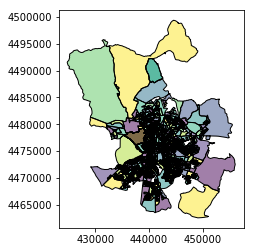

In [55]:
mad_biblio.plot()

(2373, 108)

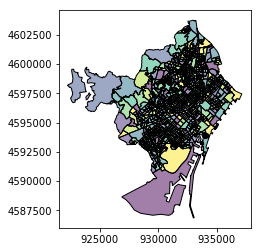

In [52]:
bcn.plot()
plt.show()

In [ ]:
#para hacer un merge de 2 csv
#union=secciones.merge(madiva,how='inner',left_on='PRMUDISEC',right_on='PRO+MUN+DIS+SEC')